# Image Denoising as an Example of a Graphical model
***
This script demonstates the practical use of graphical models by giving an example in the domain of image denoising. This very simple example allows to display the effectivity of graphical models. However, this framework is not restricted to simple tasks as the model complexity can be increased while retraining a clear understanding of the algorithm. 

## The Graphical Model

![Image](notebook_imgs/markov.png)
<div style="text-align: right">*Image Source: Pattern Recognition and Machine Learning by Christopher Bishop*</div>

The problem is modelled as an undirected graph, also called Markov random field. It contains a grid of unobserved nodes x_i, which are binary random variables describing the value of the unknown noise-free pixel values. In this simple model, they are only connected two the four neighbouring nodes as well as the respective y_i node. The y_i's are the grid of observed pixel values of the noisy image. Our goal is to infer the x_i by observing the y_i.

In the following, it is assumed that a pixel value can be 1 (white) or -1 (black).

## The Joint Probability Distribution

In order to obtain the joint probability distribution in a undirected graphical model, we need to multiply over all maximal cliques: $$p(x, y) = \frac{1}{Z} \prod_C \phi_C(x_C, y_C)$$
In this case, we have two types of maximal cliques: 
1. Each $x_i$ with its corresponding $y_i$
2. All combinations of $x_i$ and $x_j$ which are adjacent

We choose simple potential functions for these situations:
1. $\phi(x_i, x_j) = \exp(\eta \cdot x_i \cdot x_j)$. It expresses the fact that similar values of neighbouring pixels are more likely than different ones (for positive $\eta$)
2. $\phi(x_i, y_i) = \exp(\beta \cdot x_i \cdot y_i + h \cdot x_i)$. It expresses the idea that 1.) the noisy pixel is more likely to be right than wrong (for positive $\beta$) and 2.) white pixels are more likely than black pixels (for positive $h$).

This way, we obtain the following formula for the joint distribution: $$p(x, y) = \frac{1}{Z} \exp(\beta\sum_{i, j}x_i \cdot x_j + \eta\sum_i x_i \cdot y_i + h\sum_i x_i)$$
The negative of the exponent is often called energy function, so that $$p(x, y) = \frac{1}{Z} \exp(-E(x, y)) \text{ with } E(x, y) = -\beta\sum_{i, j}x_i \cdot x_j -\eta\sum_i x_i \cdot y_i - h\sum_i x_i$$

## Inferring the Noise-free Image

We observe the $y_i$ (the pixels of the noisy image) and we wish to recover the pixel values $x_i$ with the highest probability. Thus, we would like to obtain the $x_i$ which maximise p(x|y). In this case, we use a very simple algorithm with the following steps:
1. Initialise the $x_i$ with the values of $y_i$
2. For each $x_i$, calculate the energy values for $x_i = 1$ and $x_i = -1$, and set it to the value which minimises the energy function. In practice, we only need to calculate the values which are changed by $x_i$, so that this calculation becomes a local one.
3. Repeat step 2 until a convergence criteria is achieved

If we look at the energy function $E(x, y)$, we can see that for a respective $x_i$, it can be reformulated as $$E(x_i) = -\beta\sum_j x_i \cdot x_j - \eta \cdot x_i \cdot y_i - h \cdot x_i + const$$ where const represents a term not depending on $x_i$. Thus, we only need to make a few calculations for each $x_i$ and each possible value (-1 or 1). 

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import cv2
%matplotlib inline

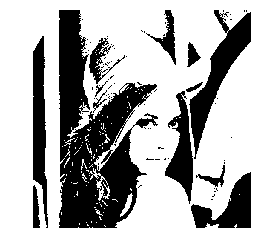

In [2]:
lenna_img = cv2.imread('lenna.png', cv2.IMREAD_GRAYSCALE)
lenna_img_bw = np.zeros(lenna_img.shape)
lenna_img_bw[lenna_img > 128] = 1
plt.imshow(lenna_img_bw)
plt.set_cmap('gray')
a = plt.axis("off")

Make noisy image

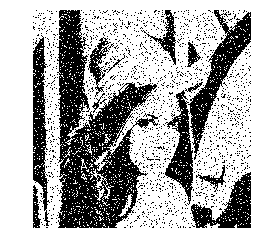

In [3]:
p = 0.1
lenna_noisy = np.zeros(lenna_img_bw.shape)
for i in range(512):
    for j in range(512):
        if np.random.binomial(1, p): # Flip value
            if lenna_img_bw[i, j]:
                lenna_noisy[i, j] = 0
            else:
                lenna_noisy[i, j] = 1
        else:
            lenna_noisy[i, j] = lenna_img_bw[i, j]

plt.imshow(lenna_noisy)
plt.set_cmap('gray')
a = plt.axis("off")

We use iterated conditional modes (ICM)

In [7]:
y = lenna_noisy
x = y # Initialisation of x

x[x==0] = -1
y[y==0] = -1

# Set parameters
h = 0
beta = 4.0
eta = 0.02

def local_energy(i, j, x, y):
    energy = h * x[i, j]
    s = 0
    for k in [(i-1, j), (i+1, j), (i, j-1), (i, j+1)]:
        if k[0] >= 0 and k[0] <= 511 and k[1] >= 0 and k[1] <= 511:
            s += x[k]
    energy -= eta * x[i, j] * s
    energy -= beta * x[i, j] * y[i, j]
    return energy

In [8]:
for k in range(10):
    for i in range(512):
        for j in range(512):
            le1 = local_energy(i, j, x, y)
            x[i, j] = -x[i, j]
            le2 = local_energy(i, j, x, y)
            if le1 < le2:
                x[i, j] = -x[i, j]
    print('Done with epoch', k)

Done with epoch 0
Done with epoch 1
Done with epoch 2
Done with epoch 3
Done with epoch 4
Done with epoch 5
Done with epoch 6
Done with epoch 7
Done with epoch 8
Done with epoch 9


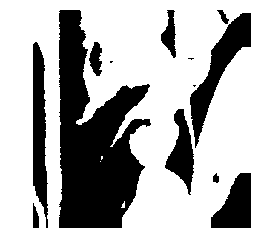

In [9]:
x[x==-1] = 0
plt.imshow(x)
plt.set_cmap('gray')
a = plt.axis("off")